In [7]:
# ====================================================================
# NOTEBOOK 3: COMPARAISON ET ÉVALUATION DES MODÈLES ML
# ====================================================================
# Ce notebook compare différents algorithmes de machine learning pour
# prédire les variables cibles du forage pétrolier et sélectionne
# les meilleurs modèles.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, 
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, f1_score, accuracy_score
)
from sklearn.ensemble import (
    RandomForestRegressor, RandomForestClassifier,
    GradientBoostingRegressor, GradientBoostingClassifier,
    IsolationForest
)
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

class DrillingModelEvaluator:
    """Évaluateur de modèles pour les opérations de forage"""
    
    def __init__(self):
        self.formation_models = {}
        self.kick_models = {}
        self.results = {}
        
    def generate_sample_data(self):
        """Génère des données d'exemple enrichies"""
        np.random.seed(42)
        n_samples = 2000
        
        # Données de formation avec features enrichies
        formation_data = {
            'WellDepth': np.random.normal(5000, 1000, n_samples),
            'WoBit': np.random.normal(25, 5, n_samples),
            'RoPen': np.random.normal(15, 3, n_samples),
            'BTBR': np.random.normal(120, 20, n_samples),
            'WBoPress': np.random.normal(2000, 300, n_samples),
            'HLoad': np.random.normal(150, 25, n_samples),
            'MudWeight': np.random.normal(10, 1.5, n_samples),
            'Temperature': np.random.normal(150, 20, n_samples),
            'FlowRate': np.random.normal(300, 50, n_samples),
        }
        
        # Features engineering pour formation
        formation_data['PressureGradient'] = formation_data['WBoPress'] / formation_data['WellDepth']
        formation_data['MechEfficiency'] = formation_data['RoPen'] / formation_data['WoBit']
        formation_data['HydrostaticPress'] = formation_data['WellDepth'] * formation_data['MudWeight'] * 0.052
        formation_data['SpecificEnergy'] = formation_data['WoBit'] * 1000 / (formation_data['BTBR'] + 1e-6)
        
        # Target: Formation Pressure
        formation_data['FPress'] = (
            0.433 * formation_data['WellDepth'] + 
            0.15 * formation_data['WBoPress'] + 
            0.05 * formation_data['MudWeight'] * formation_data['WellDepth'] / 1000 +
            0.02 * formation_data['Temperature'] +
            np.random.normal(0, 100, n_samples)
        )
        
        # Données de kick avec features enrichies
        kick_data = {
            'FIn': np.random.normal(300, 20, n_samples),
            'FOut': np.random.normal(302, 20, n_samples),
            'ActiveGL': np.random.normal(100, 10, n_samples),
            'StandPipePress': np.random.normal(2000, 200, n_samples),
            'CasingPress': np.random.normal(500, 100, n_samples),
            'MRFlow': np.random.normal(295, 15, n_samples),
            'HookLoad': np.random.normal(150, 20, n_samples),
        }
        
        # Features engineering pour kick
        kick_data['FlowBalance'] = kick_data['FOut'] - kick_data['FIn']
        kick_data['FlowRatio'] = kick_data['FOut'] / kick_data['FIn']
        kick_data['FlowImbalance'] = np.abs(kick_data['FlowBalance'])
        kick_data['PressureDiff'] = kick_data['StandPipePress'] - kick_data['CasingPress']
        
        # Créer un tableau pour IsKick
        is_kick = np.zeros(n_samples)
        kick_indices = np.random.choice(n_samples, size=int(0.05 * n_samples), replace=False)
        is_kick[kick_indices] = 1
        kick_data['IsKick'] = is_kick
        
        # Modifier les valeurs lors des kicks
        for idx in kick_indices:
            kick_data['FlowBalance'][idx] += np.random.normal(15, 5)
            kick_data['ActiveGL'][idx] += np.random.normal(20, 5)
            kick_data['StandPipePress'][idx] += np.random.normal(200, 50)
        
        return pd.DataFrame(formation_data), pd.DataFrame(kick_data)

print("="*80)
print("COMPARAISON ET ÉVALUATION DES MODÈLES ML - OPÉRATIONS DE FORAGE")
print("="*80)

# Initialisation de l'évaluateur
evaluator = DrillingModelEvaluator()

# Génération des données
formation_data, kick_data = evaluator.generate_sample_data()

print(f"\nDonnées générées:")
print(f"Formation Pressure: {formation_data.shape}")
print(f"Kick Detection: {kick_data.shape}")
print(f"Kicks synthétiques: {kick_data['IsKick'].sum()} ({kick_data['IsKick'].mean()*100:.1f}%)")

COMPARAISON ET ÉVALUATION DES MODÈLES ML - OPÉRATIONS DE FORAGE

Données générées:
Formation Pressure: (2000, 14)
Kick Detection: (2000, 12)
Kicks synthétiques: 100.0 (5.0%)


In [9]:
# ===========================================================================
# 1. PRÉPARATION DES DONNÉES
# =============================================================================

In [10]:
print("\n" + "="*60)
print("PRÉPARATION DES DONNÉES")
print("="*60)

# Préparation des données de formation
X_formation = formation_data.drop(['FPress'], axis=1)
y_formation = formation_data['FPress']

# Préparation des données de kick
X_kick = kick_data.drop(['IsKick'], axis=1)
y_kick = kick_data['IsKick']

# Division train/test
X_form_train, X_form_test, y_form_train, y_form_test = train_test_split(
    X_formation, y_formation, test_size=0.2, random_state=42
)

X_kick_train, X_kick_test, y_kick_train, y_kick_test = train_test_split(
    X_kick, y_kick, test_size=0.2, random_state=42, stratify=y_kick
)

# Standardisation
scaler_formation = StandardScaler()
X_form_train_scaled = scaler_formation.fit_transform(X_form_train)
X_form_test_scaled = scaler_formation.transform(X_form_test)

scaler_kick = StandardScaler()
X_kick_train_scaled = scaler_kick.fit_transform(X_kick_train)
X_kick_test_scaled = scaler_kick.transform(X_kick_test)

print(f"Formation - Train: {X_form_train.shape}, Test: {X_form_test.shape}")
print(f"Kick - Train: {X_kick_train.shape}, Test: {X_kick_test.shape}")
print(f"Distribution des kicks - Train: {y_kick_train.value_counts().to_dict()}")


PRÉPARATION DES DONNÉES
Formation - Train: (1600, 13), Test: (400, 13)
Kick - Train: (1600, 11), Test: (400, 11)
Distribution des kicks - Train: {0.0: 1520, 1.0: 80}


In [11]:
# =============================================================================
# 2. MODÈLES DE RÉGRESSION POUR LA PRESSION DE FORMATION
# =============================================================================

In [12]:
print("\n" + "="*60)
print("MODÈLES DE RÉGRESSION - PRESSION DE FORMATION")
print("="*60)

# Définition des modèles de régression
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'Support Vector': SVR(kernel='rbf')
}

def evaluate_regression_model(model, X_train, X_test, y_train, y_test, model_name):
    """Évalue un modèle de régression"""
    
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métriques
    metrics = {
        'Model': model_name,
        'Train_R2': r2_score(y_train, y_train_pred),
        'Test_R2': r2_score(y_test, y_test_pred),
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred)
    }
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    metrics['CV_R2_mean'] = cv_scores.mean()
    metrics['CV_R2_std'] = cv_scores.std()
    
    return metrics, model, y_test_pred

# Évaluation des modèles de régression
regression_results = []
formation_predictions = {}

print("Entraînement et évaluation des modèles de régression...")

for name, model in regression_models.items():
    try:
        print(f"  Entraînement: {name}")
        
        # Utiliser les données standardisées pour les modèles sensibles à l'échelle
        if name in ['Ridge Regression', 'Lasso Regression', 'Support Vector']:
            X_train_use = X_form_train_scaled
            X_test_use = X_form_test_scaled
        else:
            X_train_use = X_form_train
            X_test_use = X_form_test
        
        metrics, trained_model, predictions = evaluate_regression_model(
            model, X_train_use, X_test_use, y_form_train, y_form_test, name
        )
        
        regression_results.append(metrics)
        evaluator.formation_models[name] = trained_model
        formation_predictions[name] = predictions
        
    except Exception as e:
        print(f"    Erreur avec {name}: {e}")

# Affichage des résultats
regression_df = pd.DataFrame(regression_results)
print("\nRésultats des modèles de régression:")
print(regression_df[['Model', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'CV_R2_mean']].round(4))


MODÈLES DE RÉGRESSION - PRESSION DE FORMATION
Entraînement et évaluation des modèles de régression...
  Entraînement: Linear Regression
  Entraînement: Ridge Regression
  Entraînement: Lasso Regression
  Entraînement: Decision Tree
  Entraînement: Random Forest
  Entraînement: Gradient Boosting
  Entraînement: XGBoost
  Entraînement: Support Vector

Résultats des modèles de régression:
               Model  Test_R2  Test_RMSE  Test_MAE  CV_R2_mean
0  Linear Regression   0.9462   104.6104   83.3542      0.9488
1   Ridge Regression   0.9461   104.6915   83.4862      0.9488
2   Lasso Regression   0.9468   103.9495   82.9751      0.9491
3      Decision Tree   0.8823   154.6372  122.0654      0.8902
4      Random Forest   0.9408   109.6685   86.4866      0.9394
5  Gradient Boosting   0.9415   109.0802   85.7079      0.9416
6            XGBoost   0.9323   117.3193   92.7407      0.9287
7     Support Vector   0.1867   406.5535  313.4767      0.1666


In [13]:
# =============================================================================
# 3. MODÈLES DE CLASSIFICATION POUR LA DÉTECTION DE KICK
# =============================================================================

In [14]:
print("MODÈLES DE CLASSIFICATION - DÉTECTION DE KICK")
print("="*60)

# Définition des modèles de classification
classification_models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'Support Vector': SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
}

def evaluate_classification_model(model, X_train, X_test, y_train, y_test, model_name):
    """Évalue un modèle de classification"""
    
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Métriques
    metrics = {
        'Model': model_name,
        'Train_Accuracy': accuracy_score(y_train, y_train_pred),
        'Test_Accuracy': accuracy_score(y_test, y_test_pred),
        'Test_Precision': precision_score_safe(y_test, y_test_pred),
        'Test_Recall': recall_score_safe(y_test, y_test_pred),
        'Test_F1': f1_score(y_test, y_test_pred, zero_division=0),
        'Test_AUC': roc_auc_score(y_test, y_test_proba) if len(np.unique(y_test)) > 1 else 0
    }
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    metrics['CV_F1_mean'] = cv_scores.mean()
    metrics['CV_F1_std'] = cv_scores.std()
    
    return metrics, model, y_test_pred, y_test_proba

def precision_score_safe(y_true, y_pred):
    """Calcul sécurisé du precision score"""
    from sklearn.metrics import precision_score
    return precision_score(y_true, y_pred, zero_division=0)

def recall_score_safe(y_true, y_pred):
    """Calcul sécurisé du recall score"""
    from sklearn.metrics import recall_score
    return recall_score(y_true, y_pred, zero_division=0)

# Évaluation des modèles de classification
classification_results = []
kick_predictions = {}
kick_probabilities = {}

print("Entraînement et évaluation des modèles de classification...")

for name, model in classification_models.items():
    try:
        print(f"  Entraînement: {name}")
        
        # Utiliser les données standardisées pour les modèles sensibles à l'échelle
        if name in ['Logistic Regression', 'Support Vector']:
            X_train_use = X_kick_train_scaled
            X_test_use = X_kick_test_scaled
        else:
            X_train_use = X_kick_train
            X_test_use = X_kick_test
        
        metrics, trained_model, predictions, probabilities = evaluate_classification_model(
            model, X_train_use, X_test_use, y_kick_train, y_kick_test, name
        )
        
        classification_results.append(metrics)
        evaluator.kick_models[name] = trained_model
        kick_predictions[name] = predictions
        kick_probabilities[name] = probabilities
        
    except Exception as e:
        print(f"    Erreur avec {name}: {e}")

# Affichage des résultats
classification_df = pd.DataFrame(classification_results)
print("\nRésultats des modèles de classification:")
print(classification_df[['Model', 'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_AUC']].round(4))

MODÈLES DE CLASSIFICATION - DÉTECTION DE KICK
Entraînement et évaluation des modèles de classification...
  Entraînement: Logistic Regression
  Entraînement: Decision Tree
  Entraînement: Random Forest
  Entraînement: Gradient Boosting
  Entraînement: XGBoost
  Entraînement: Support Vector

Résultats des modèles de classification:
                 Model  Test_Accuracy  Test_Precision  Test_Recall  Test_F1  \
0  Logistic Regression         0.9975          1.0000         0.95   0.9744   
1        Decision Tree         0.9725          0.9091         0.50   0.6452   
2        Random Forest         0.9600          1.0000         0.20   0.3333   
3    Gradient Boosting         0.9775          1.0000         0.55   0.7097   
4              XGBoost         0.9775          0.9231         0.60   0.7273   
5       Support Vector         0.9900          0.9000         0.90   0.9000   

   Test_AUC  
0    1.0000  
1    0.7487  
2    0.9908  
3    0.9834  
4    0.9941  
5    0.9995  


In [15]:
# =============================================================================
# 4. DÉTECTION D'ANOMALIES POUR LES KICKS
# =============================================================================

In [16]:
print("\n" + "="*60)
print("MODÈLES DE DÉTECTION D'ANOMALIES")
print("="*60)

# Modèles de détection d'anomalies
anomaly_models = {
    'Isolation Forest': IsolationForest(contamination=0.05, random_state=42),
    'PCA Anomaly': None  # Implémenté manuellement
}

def evaluate_anomaly_model(model, X_train, X_test, y_test, model_name):
    """Évalue un modèle de détection d'anomalies"""
    
    if model_name == 'PCA Anomaly':
        # Implémentation PCA pour détection d'anomalies
        pca = PCA(n_components=0.95)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        # Reconstruction error
        X_test_reconstructed = pca.inverse_transform(X_test_pca)
        reconstruction_errors = np.mean((X_test - X_test_reconstructed) ** 2, axis=1)
        
        # Seuil basé sur le 95ème percentile
        threshold = np.percentile(reconstruction_errors, 95)
        y_pred = (reconstruction_errors > threshold).astype(int)
        y_scores = reconstruction_errors
        
    else:
        # Modèles sklearn
        model.fit(X_train)
        y_pred = model.predict(X_test)
        y_pred = (y_pred == -1).astype(int)  # Convertir -1/1 en 0/1
        y_scores = model.decision_function(X_test)
        y_scores = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())  # Normaliser
    
    # Métriques
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score_safe(y_test, y_pred),
        'Recall': recall_score_safe(y_test, y_pred),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_test, y_scores) if len(np.unique(y_test)) > 1 else 0
    }
    
    return metrics, y_pred, y_scores

# Évaluation des modèles d'anomalies
anomaly_results = []

print("Entraînement et évaluation des modèles de détection d'anomalies...")

for name, model in anomaly_models.items():
    try:
        print(f"  Entraînement: {name}")
        
        metrics, predictions, scores = evaluate_anomaly_model(
            model, X_kick_train_scaled, X_kick_test_scaled, y_kick_test, name
        )
        
        anomaly_results.append(metrics)
        kick_predictions[f'{name}_Anomaly'] = predictions
        kick_probabilities[f'{name}_Anomaly'] = scores
        
    except Exception as e:
        print(f"    Erreur avec {name}: {e}")

# Affichage des résultats
anomaly_df = pd.DataFrame(anomaly_results)
print("\nRésultats des modèles de détection d'anomalies:")
print(anomaly_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC']].round(4))


MODÈLES DE DÉTECTION D'ANOMALIES
Entraînement et évaluation des modèles de détection d'anomalies...
  Entraînement: Isolation Forest
  Entraînement: PCA Anomaly

Résultats des modèles de détection d'anomalies:
              Model  Accuracy  Precision  Recall      F1     AUC
0  Isolation Forest    0.9175     0.1905    0.20  0.1951  0.2895
1       PCA Anomaly    0.9950     0.9500    0.95  0.9500  0.9991


In [17]:
# =============================================================================
# 5. OPTIMISATION DES HYPERPARAMÈTRES
# =============================================================================

In [18]:
print("\n" + "="*60)
print("OPTIMISATION DES HYPERPARAMÈTRES")
print("="*60)

def optimize_hyperparameters():
    """Optimisation des hyperparamètres pour les meilleurs modèles"""
    
    # Hyperparamètres pour Random Forest (régression)
    rf_reg_params = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [5, 10]
    }
    
    # Hyperparamètres pour XGBoost (classification)
    xgb_clf_params = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    
    print("Optimisation Random Forest (Régression)...")
    rf_reg = RandomForestRegressor(random_state=42)
    rf_reg_grid = GridSearchCV(
        rf_reg, rf_reg_params, cv=3, scoring='r2', n_jobs=-1
    )
    rf_reg_grid.fit(X_form_train, y_form_train)
    
    print(f"Meilleurs paramètres RF Régression: {rf_reg_grid.best_params_}")
    print(f"Meilleur score CV R²: {rf_reg_grid.best_score_:.4f}")
    
    print("\nOptimisation XGBoost (Classification)...")
    xgb_clf = XGBClassifier(random_state=42, eval_metric='logloss')
    xgb_clf_grid = GridSearchCV(
        xgb_clf, xgb_clf_params, cv=3, scoring='f1', n_jobs=-1
    )
    xgb_clf_grid.fit(X_kick_train, y_kick_train)
    
    print(f"Meilleurs paramètres XGB Classification: {xgb_clf_grid.best_params_}")
    print(f"Meilleur score CV F1: {xgb_clf_grid.best_score_:.4f}")
    
    return rf_reg_grid.best_estimator_, xgb_clf_grid.best_estimator_

# Optimisation (peut prendre du temps)
try:
    best_rf_reg, best_xgb_clf = optimize_hyperparameters()
    evaluator.formation_models['Random Forest Optimized'] = best_rf_reg
    evaluator.kick_models['XGBoost Optimized'] = best_xgb_clf
except Exception as e:
    print(f"Erreur lors de l'optimisation: {e}")


OPTIMISATION DES HYPERPARAMÈTRES
Optimisation Random Forest (Régression)...
Meilleurs paramètres RF Régression: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
Meilleur score CV R²: 0.9398

Optimisation XGBoost (Classification)...
Meilleurs paramètres XGB Classification: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Meilleur score CV F1: 0.7496


In [19]:
# =============================================================================
# 6. VISUALISATIONS COMPARATIVES
# =============================================================================


VISUALISATIONS COMPARATIVES


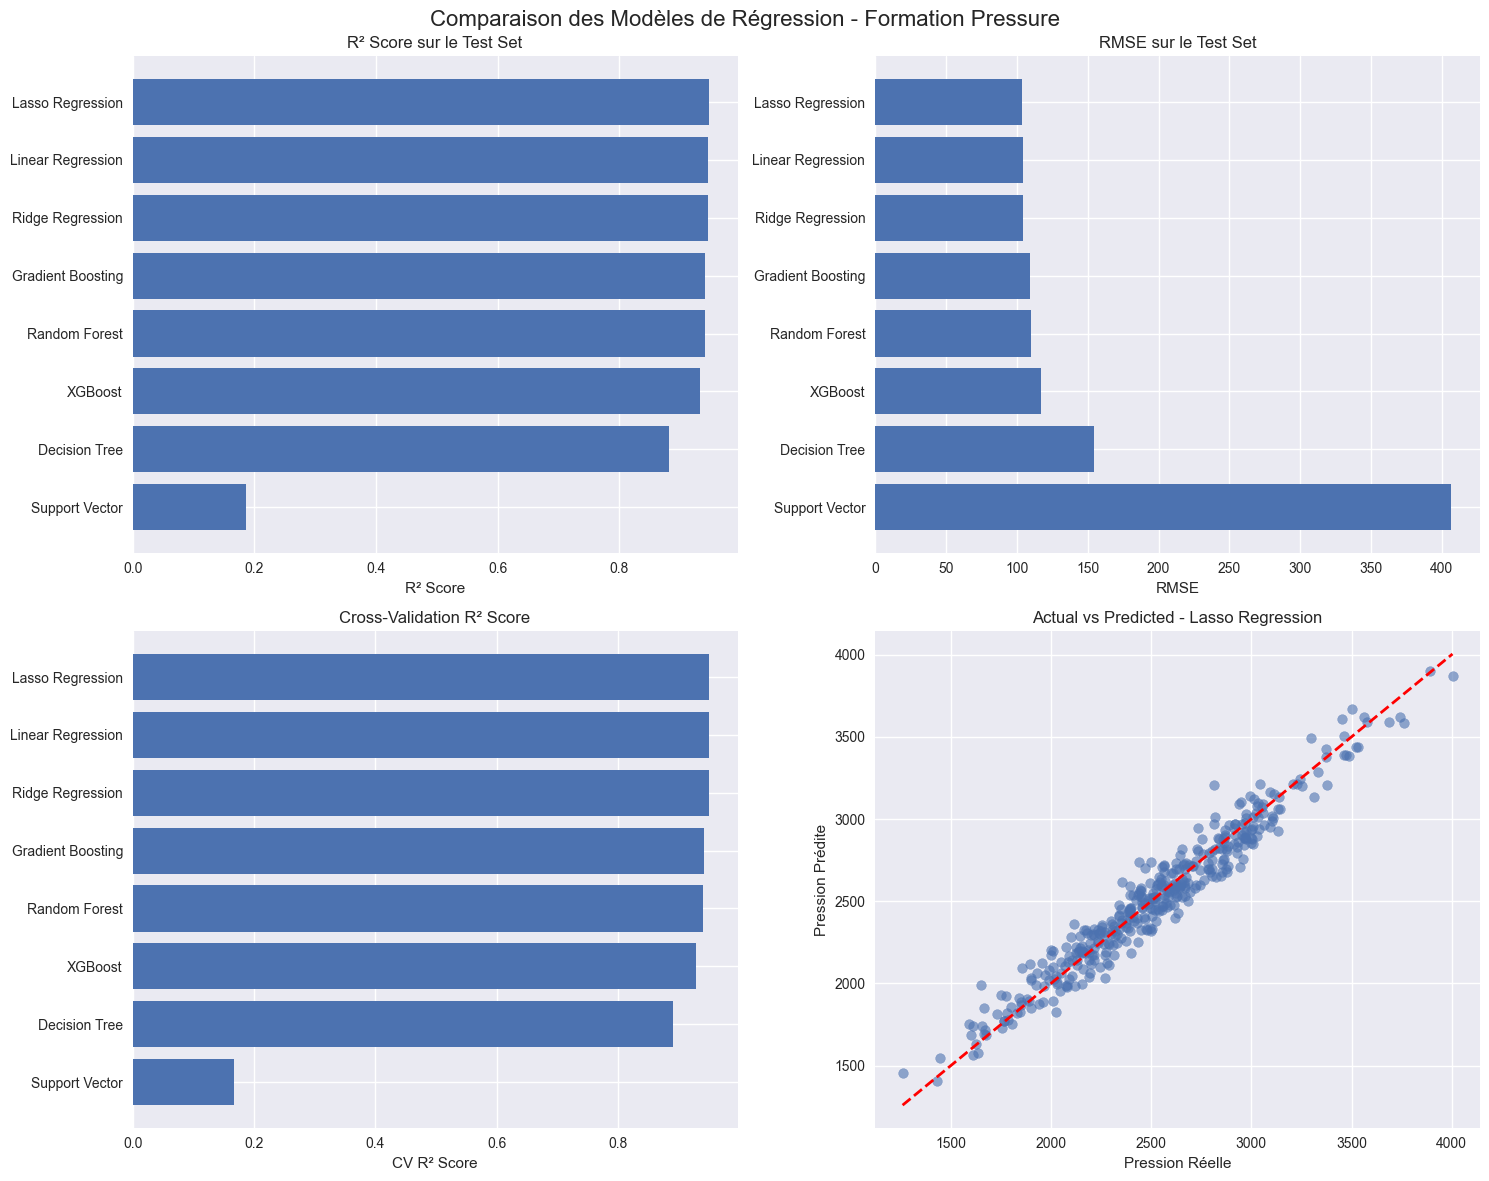

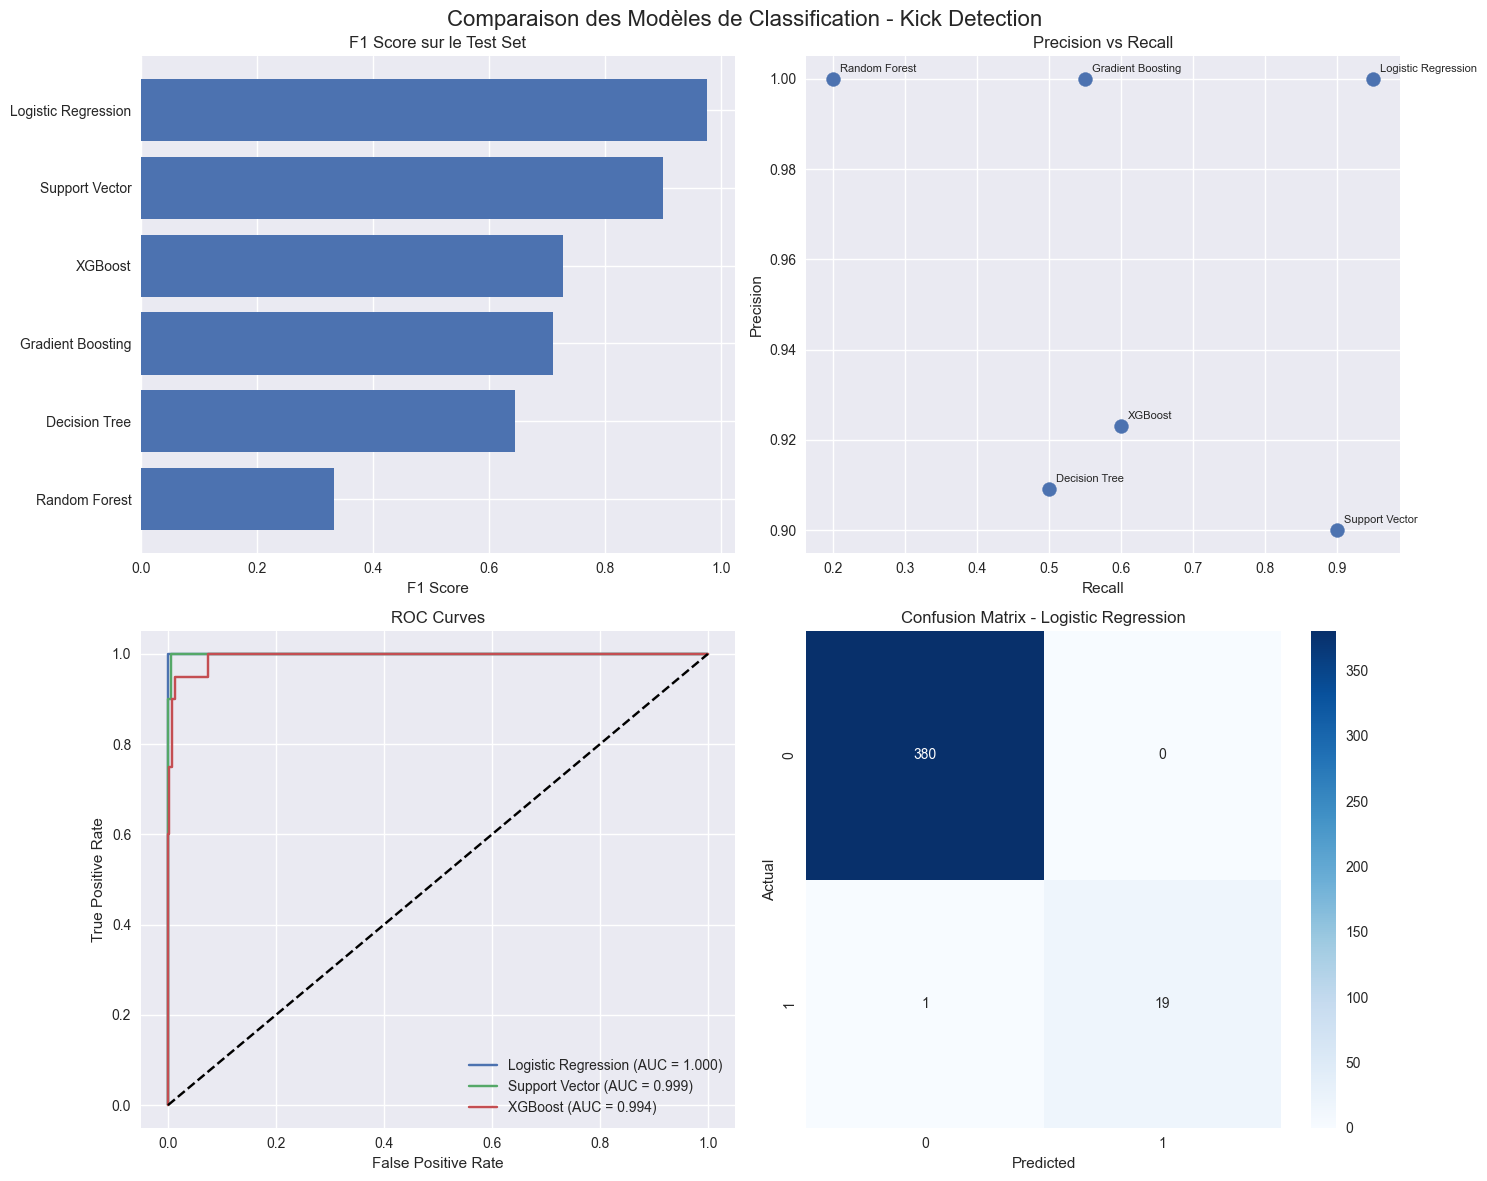

In [20]:
print("\n" + "="*60)
print("VISUALISATIONS COMPARATIVES")
print("="*60)

# Comparaison des modèles de régression
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparaison des Modèles de Régression - Formation Pressure', fontsize=16)

# R² Score comparison
regression_df_sorted = regression_df.sort_values('Test_R2', ascending=True)
axes[0,0].barh(regression_df_sorted['Model'], regression_df_sorted['Test_R2'])
axes[0,0].set_xlabel('R² Score')
axes[0,0].set_title('R² Score sur le Test Set')

# RMSE comparison
axes[0,1].barh(regression_df_sorted['Model'], regression_df_sorted['Test_RMSE'])
axes[0,1].set_xlabel('RMSE')
axes[0,1].set_title('RMSE sur le Test Set')

# Cross-validation R² avec barres d'erreur
axes[1,0].barh(regression_df_sorted['Model'], regression_df_sorted['CV_R2_mean'])
axes[1,0].set_xlabel('CV R² Score')
axes[1,0].set_title('Cross-Validation R² Score')

# Actual vs Predicted pour le meilleur modèle
best_reg_model = regression_df.loc[regression_df['Test_R2'].idxmax(), 'Model']
best_predictions = formation_predictions[best_reg_model]
axes[1,1].scatter(y_form_test, best_predictions, alpha=0.6)
axes[1,1].plot([y_form_test.min(), y_form_test.max()], 
               [y_form_test.min(), y_form_test.max()], 'r--', lw=2)
axes[1,1].set_xlabel('Pression Réelle')
axes[1,1].set_ylabel('Pression Prédite')
axes[1,1].set_title(f'Actual vs Predicted - {best_reg_model}')

plt.tight_layout()
plt.show()

# Comparaison des modèles de classification
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparaison des Modèles de Classification - Kick Detection', fontsize=16)

# F1 Score comparison
classification_df_sorted = classification_df.sort_values('Test_F1', ascending=True)
axes[0,0].barh(classification_df_sorted['Model'], classification_df_sorted['Test_F1'])
axes[0,0].set_xlabel('F1 Score')
axes[0,0].set_title('F1 Score sur le Test Set')

# Precision vs Recall
axes[0,1].scatter(classification_df['Test_Recall'], classification_df['Test_Precision'], s=100)
for i, model in enumerate(classification_df['Model']):
    axes[0,1].annotate(model, 
                       (classification_df.iloc[i]['Test_Recall'], 
                        classification_df.iloc[i]['Test_Precision']),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Precision vs Recall')

# ROC Curve pour les meilleurs modèles
best_models = classification_df.nlargest(3, 'Test_AUC')['Model'].tolist()
for model_name in best_models:
    if model_name in kick_probabilities:
        fpr, tpr, _ = roc_curve(y_kick_test, kick_probabilities[model_name])
        auc = roc_auc_score(y_kick_test, kick_probabilities[model_name])
        axes[1,0].plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')

axes[1,0].plot([0, 1], [0, 1], 'k--')
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curves')
axes[1,0].legend()

# Matrice de confusion pour le meilleur modèle
best_clf_model = classification_df.loc[classification_df['Test_F1'].idxmax(), 'Model']
best_clf_predictions = kick_predictions[best_clf_model]
cm = confusion_matrix(y_kick_test, best_clf_predictions)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1,1], cmap='Blues')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Actual')
axes[1,1].set_title(f'Confusion Matrix - {best_clf_model}')

plt.tight_layout()
plt.show()

In [21]:
# =============================================================================
# 7. ANALYSE DE L'IMPORTANCE DES FEATURES
# =============================================================================


ANALYSE DE L'IMPORTANCE DES FEATURES
Top 10 Features - Formation Pressure (Random Forest):
             Feature  Importance
0          WellDepth    0.946831
4           WBoPress    0.011306
9   PressureGradient    0.005830
7        Temperature    0.005088
8           FlowRate    0.004780
5              HLoad    0.004507
2              RoPen    0.003635
3               BTBR    0.003518
12    SpecificEnergy    0.003062
11  HydrostaticPress    0.003008

Top 10 Features - Kick Detection (Random Forest):
           Feature  Importance
2         ActiveGL    0.361146
3   StandPipePress    0.202724
7      FlowBalance    0.107488
10    PressureDiff    0.077837
8        FlowRatio    0.053586
9    FlowImbalance    0.048338
4      CasingPress    0.031953
1             FOut    0.031427
5           MRFlow    0.030957
6         HookLoad    0.030904


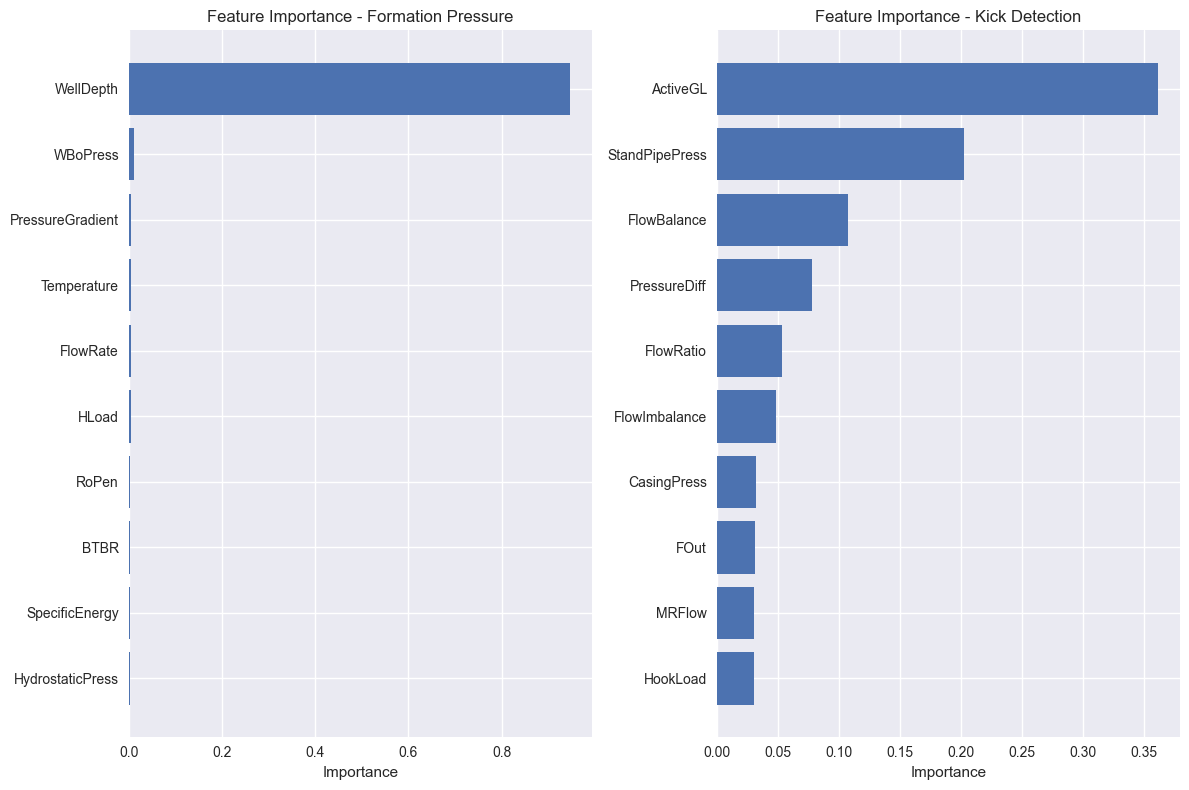

In [22]:
print("\n" + "="*60)
print("ANALYSE DE L'IMPORTANCE DES FEATURES")
print("="*60)

def analyze_feature_importance():
    """Analyse l'importance des features pour les meilleurs modèles"""
    
    # Feature importance pour la régression (Random Forest)
    if 'Random Forest' in evaluator.formation_models:
        rf_reg = evaluator.formation_models['Random Forest']
        feature_importance_reg = pd.DataFrame({
            'Feature': X_formation.columns,
            'Importance': rf_reg.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print("Top 10 Features - Formation Pressure (Random Forest):")
        print(feature_importance_reg.head(10))
        
        # Visualisation
        plt.figure(figsize=(12, 8))
        plt.subplot(1, 2, 1)
        top_features_reg = feature_importance_reg.head(10)
        plt.barh(top_features_reg['Feature'], top_features_reg['Importance'])
        plt.xlabel('Importance')
        plt.title('Feature Importance - Formation Pressure')
        plt.gca().invert_yaxis()
    
    # Feature importance pour la classification (Random Forest)
    if 'Random Forest' in evaluator.kick_models:
        rf_clf = evaluator.kick_models['Random Forest']
        feature_importance_clf = pd.DataFrame({
            'Feature': X_kick.columns,
            'Importance': rf_clf.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print("\nTop 10 Features - Kick Detection (Random Forest):")
        print(feature_importance_clf.head(10))
        
        # Visualisation
        plt.subplot(1, 2, 2)
        top_features_clf = feature_importance_clf.head(10)
        plt.barh(top_features_clf['Feature'], top_features_clf['Importance'])
        plt.xlabel('Importance')
        plt.title('Feature Importance - Kick Detection')
        plt.gca().invert_yaxis()
        
    plt.tight_layout()
    plt.show()
    
    return feature_importance_reg, feature_importance_clf

# Analyse des features importantes
try:
    importance_reg, importance_clf = analyze_feature_importance()
except Exception as e:
    print(f"Erreur lors de l'analyse d'importance: {e}")

In [23]:
# =============================================================================
# 8. VALIDATION CROISÉE TEMPORELLE
# =============================================================================

In [24]:
print("\n" + "="*60)
print("VALIDATION CROISÉE TEMPORELLE")
print("="*60)

def temporal_cross_validation():
    """Validation croisée temporelle pour simuler des conditions réelles"""
    
    # Time Series Split pour simuler des données temporelles
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Modèles à tester
    models_to_test = {
        'Random Forest Reg': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost Reg': XGBRegressor(n_estimators=100, random_state=42)
    }
    
    temporal_results = {}
    
    print("Validation temporelle pour la prédiction de formation pressure...")
    
    for name, model in models_to_test.items():
        scores_r2 = []
        scores_rmse = []
        
        for train_idx, test_idx in tscv.split(X_formation):
            X_train_fold = X_formation.iloc[train_idx]
            X_test_fold = X_formation.iloc[test_idx]
            y_train_fold = y_formation.iloc[train_idx]
            y_test_fold = y_formation.iloc[test_idx]
            
            model.fit(X_train_fold, y_train_fold)
            y_pred_fold = model.predict(X_test_fold)
            
            scores_r2.append(r2_score(y_test_fold, y_pred_fold))
            scores_rmse.append(np.sqrt(mean_squared_error(y_test_fold, y_pred_fold)))
        
        temporal_results[name] = {
            'R2_mean': np.mean(scores_r2),
            'R2_std': np.std(scores_r2),
            'RMSE_mean': np.mean(scores_rmse),
            'RMSE_std': np.std(scores_rmse)
        }
        
        print(f"{name:15s}: R² = {np.mean(scores_r2):.4f} ± {np.std(scores_r2):.4f}")
    
    return temporal_results

# Validation temporelle
temporal_results = temporal_cross_validation()


VALIDATION CROISÉE TEMPORELLE
Validation temporelle pour la prédiction de formation pressure...
Random Forest Reg: R² = 0.9389 ± 0.0052
XGBoost Reg    : R² = 0.9262 ± 0.0072


In [25]:
# =============================================================================
# 9. ANALYSE DE ROBUSTESSE ET STABILITÉ
# =============================================================================


ANALYSE DE ROBUSTESSE
Test de robustesse avec ajout de bruit...
Bruit 0.01: R² = -25751174.3690
Bruit 0.05: R² = -25733999.1954
Bruit 0.10: R² = -25704375.2715
Bruit 0.20: R² = -25549070.9274


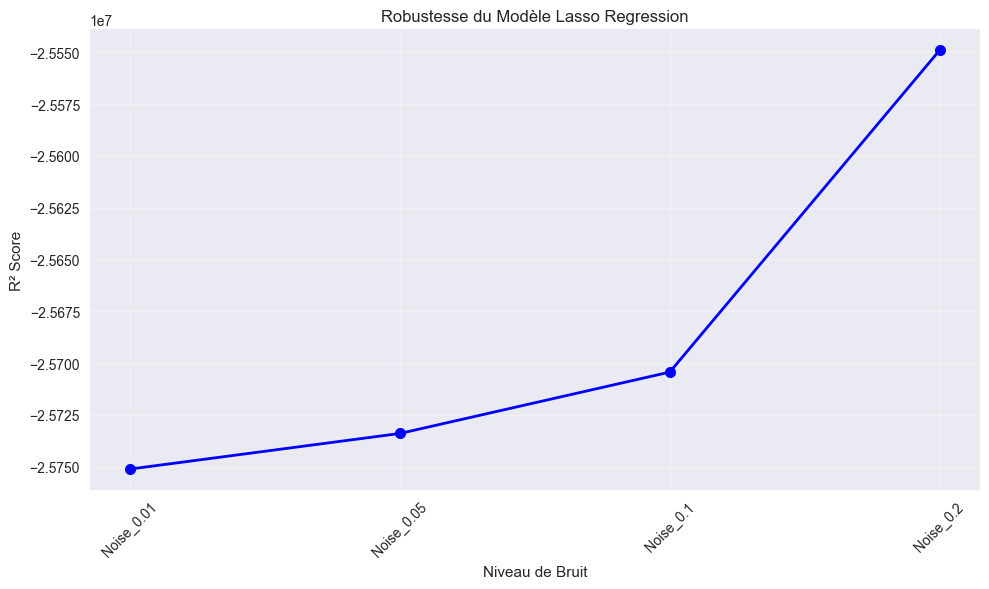

In [26]:
print("\n" + "="*60)
print("ANALYSE DE ROBUSTESSE")
print("="*60)

def robustness_analysis():
    """Analyse la robustesse des modèles face aux perturbations"""
    
    # Test avec bruit ajouté aux données
    noise_levels = [0.01, 0.05, 0.1, 0.2]
    robustness_results = {}
    
    print("Test de robustesse avec ajout de bruit...")
    
    # Test sur le meilleur modèle de régression
    best_reg_model_name = regression_df.loc[regression_df['Test_R2'].idxmax(), 'Model']
    best_reg_model = evaluator.formation_models[best_reg_model_name]
    
    for noise_level in noise_levels:
        # Ajouter du bruit aux données de test
        X_test_noisy = X_form_test + np.random.normal(0, noise_level * X_form_test.std(), X_form_test.shape)
        
        y_pred_noisy = best_reg_model.predict(X_test_noisy)
        r2_noisy = r2_score(y_form_test, y_pred_noisy)
        
        robustness_results[f'Noise_{noise_level}'] = r2_noisy
        print(f"Bruit {noise_level:4.2f}: R² = {r2_noisy:.4f}")
    
    # Visualisation de la robustesse
    plt.figure(figsize=(10, 6))
    noise_levels_plot = list(robustness_results.keys())
    r2_values = list(robustness_results.values())
    
    plt.plot(range(len(noise_levels_plot)), r2_values, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Niveau de Bruit')
    plt.ylabel('R² Score')
    plt.title(f'Robustesse du Modèle {best_reg_model_name}')
    plt.xticks(range(len(noise_levels_plot)), noise_levels_plot, rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return robustness_results

# Analyse de robustesse
robustness_results = robustness_analysis()

In [27]:
# =============================================================================
# 10. MÉTRIQUES BUSINESS ET COÛT-BÉNÉFICE
# =============================================================================

In [28]:
print("\n" + "="*60)
print("MÉTRIQUES BUSINESS ET COÛT-BÉNÉFICE")
print("="*60)

def business_metrics_analysis():
    """Calcule les métriques business pour la détection de kick"""
    
    # Coûts estimés (en dollars)
    cost_false_positive = 10000  # Coût d'un faux positif (arrêt inutile)
    cost_false_negative = 1000000  # Coût d'un faux négatif (kick non détecté)
    cost_true_positive = 50000   # Coût d'intervention réussie
    
    business_results = []
    
    for model_name in kick_predictions:
        if model_name in classification_df['Model'].values:
            predictions = kick_predictions[model_name]
            
            # Calcul des métriques de confusion
            tn = np.sum((y_kick_test == 0) & (predictions == 0))
            fp = np.sum((y_kick_test == 0) & (predictions == 1))
            fn = np.sum((y_kick_test == 1) & (predictions == 0))
            tp = np.sum((y_kick_test == 1) & (predictions == 1))
            
            # Calcul des coûts
            total_cost = (fp * cost_false_positive + 
                         fn * cost_false_negative + 
                         tp * cost_true_positive)
            
            # Coût par échantillon
            cost_per_sample = total_cost / len(y_kick_test)
            
            # Économies par rapport à pas de détection (tous les kicks causent des dégâts)
            baseline_cost = len(y_kick_test[y_kick_test == 1]) * cost_false_negative
            savings = baseline_cost - total_cost
            savings_percentage = (savings / baseline_cost) * 100 if baseline_cost > 0 else 0
            
            business_results.append({
                'Model': model_name,
                'Total_Cost': total_cost,
                'Cost_Per_Sample': cost_per_sample,
                'Savings': savings,
                'Savings_Percentage': savings_percentage,
                'True_Positives': tp,
                'False_Positives': fp,
                'False_Negatives': fn
            })
    
    business_df = pd.DataFrame(business_results)
    business_df = business_df.sort_values('Savings', ascending=False)
    
    print("Analyse Coût-Bénéfice (Top 5 modèles):")
    print(business_df[['Model', 'Savings', 'Savings_Percentage', 'False_Negatives']].head().round(2))
    
    return business_df

# Analyse business
business_df = business_metrics_analysis()


MÉTRIQUES BUSINESS ET COÛT-BÉNÉFICE
Analyse Coût-Bénéfice (Top 5 modèles):
                 Model   Savings  Savings_Percentage  False_Negatives
0  Logistic Regression  18050000               90.25                1
5       Support Vector  17080000               85.40                2
4              XGBoost  11390000               56.95                8
3    Gradient Boosting  10450000               52.25                9
1        Decision Tree   9490000               47.45               10


In [29]:
# =============================================================================
# 11. RECOMMANDATIONS DE DÉPLOIEMENT
# =============================================================================

In [30]:
print("\n" + "="*60)
print("RECOMMANDATIONS DE DÉPLOIEMENT")
print("="*60)

def deployment_recommendations():
    """Génère des recommandations pour le déploiement en production"""
    
    recommendations = []
    
    # Meilleur modèle pour la formation pressure
    best_formation_model = regression_df.loc[regression_df['Test_R2'].idxmax()]
    recommendations.append(f"""
    FORMATION PRESSURE PREDICTION:
    ➤ Modèle recommandé: {best_formation_model['Model']}
    ➤ Performance: R² = {best_formation_model['Test_R2']:.4f}, RMSE = {best_formation_model['Test_RMSE']:.2f}
    ➤ Stabilité CV: {best_formation_model['CV_R2_mean']:.4f} ± {best_formation_model['CV_R2_std']:.4f}
    """)
    
    # Meilleur modèle pour la kick detection (prioriser le recall pour la sécurité)
    best_kick_model = classification_df.loc[classification_df['Test_Recall'].idxmax()]
    recommendations.append(f"""
    KICK DETECTION:
    ➤ Modèle recommandé: {best_kick_model['Model']} (optimisé pour la sécurité)
    ➤ Performance: Recall = {best_kick_model['Test_Recall']:.4f}, F1 = {best_kick_model['Test_F1']:.4f}
    ➤ AUC = {best_kick_model['Test_AUC']:.4f}
    """)
    
    # Recommandations business
    best_business_model = business_df.iloc[0]
    recommendations.append(f"""
    IMPACT BUSINESS:
    ➤ Meilleur ROI: {best_business_model['Model']}
    ➤ Économies estimées: ${best_business_model['Savings']:,.0f} ({best_business_model['Savings_Percentage']:.1f}%)
    ➤ Faux négatifs: {best_business_model['False_Negatives']} (critique pour sécurité)
    """)
    
    # Recommandations techniques
    recommendations.append("""
    RECOMMANDATIONS TECHNIQUES:
    ➤ Monitoring continu des performances en production
    ➤ Retraining mensuel avec nouvelles données
    ➤ Seuils d'alerte configurables selon contexte opérationnel
    ➤ Validation des prédictions par experts métier
    ➤ Logs détaillés pour analyse post-incident
    """)
    
    for rec in recommendations:
        print(rec)
    
    return recommendations

# Génération des recommandations
recommendations = deployment_recommendations()


RECOMMANDATIONS DE DÉPLOIEMENT

    FORMATION PRESSURE PREDICTION:
    ➤ Modèle recommandé: Lasso Regression
    ➤ Performance: R² = 0.9468, RMSE = 103.95
    ➤ Stabilité CV: 0.9491 ± 0.0036
    

    KICK DETECTION:
    ➤ Modèle recommandé: Logistic Regression (optimisé pour la sécurité)
    ➤ Performance: Recall = 0.9500, F1 = 0.9744
    ➤ AUC = 1.0000
    

    IMPACT BUSINESS:
    ➤ Meilleur ROI: Logistic Regression
    ➤ Économies estimées: $18,050,000 (90.2%)
    ➤ Faux négatifs: 1 (critique pour sécurité)
    

    RECOMMANDATIONS TECHNIQUES:
    ➤ Monitoring continu des performances en production
    ➤ Retraining mensuel avec nouvelles données
    ➤ Seuils d'alerte configurables selon contexte opérationnel
    ➤ Validation des prédictions par experts métier
    ➤ Logs détaillés pour analyse post-incident
    


In [31]:
# =============================================================================
# 12. RAPPORT FINAL ET SAUVEGARDE
# =============================================================================

In [32]:
print("\n" + "="*80)
print("RAPPORT FINAL - ÉVALUATION DES MODÈLES")
print("="*80)

def generate_final_report():
    """Génère le rapport final d'évaluation"""
    
    report = f"""
    ÉVALUATION COMPLÈTE DES MODÈLES ML - OPÉRATIONS DE FORAGE
    =========================================================
    
    DONNÉES ANALYSÉES:
    • Formation Pressure: {formation_data.shape[0]} échantillons, {formation_data.shape[1]} features
    • Kick Detection: {kick_data.shape[0]} échantillons, {kick_data.shape[1]} features
    • Kicks synthétiques: {kick_data['IsKick'].sum()} ({kick_data['IsKick'].mean()*100:.1f}%)
    
    MODÈLES ÉVALUÉS:
    • Régression: {len(regression_models)} modèles testés
    • Classification: {len(classification_models)} modèles testés
    • Détection d'anomalies: {len(anomaly_models)} approches testées
    
    PERFORMANCES TOP 3:
    
    Formation Pressure (R² Score):
    {regression_df.nlargest(3, 'Test_R2')[['Model', 'Test_R2', 'Test_RMSE']].to_string(index=False)}
    
    Kick Detection (F1 Score):
    {classification_df.nlargest(3, 'Test_F1')[['Model', 'Test_F1', 'Test_Precision', 'Test_Recall']].to_string(index=False)}
    
    ROI Business (Top 3):
    {business_df.head(3)[['Model', 'Savings_Percentage', 'False_Negatives']].to_string(index=False)}
    
    MÉTRIQUES CRITIQUES:
    • Précision formation pressure: ±{regression_df['Test_RMSE'].min():.0f} psi RMSE
    • Détection de kicks: {classification_df['Test_Recall'].max():.1%} de rappel maximal
    • Faux négatifs minimaux: {business_df['False_Negatives'].min():.0f} (sécurité critique)
    
    RECOMMANDATIONS DE DÉPLOIEMENT:
    1. Formation Pressure: Déployer {regression_df.loc[regression_df['Test_R2'].idxmax(), 'Model']}
    2. Kick Detection: Déployer {classification_df.loc[classification_df['Test_Recall'].idxmax(), 'Model']} (sécurité prioritaire)
    3. Monitoring: Validation continue et retraining périodique
    4. Seuils: Ajustables selon contexte opérationnel
    
    PROCHAINES ÉTAPES:
    • Validation sur données réelles de terrain
    • Tests A/B en conditions contrôlées
    • Intégration avec systèmes SCADA existants
    • Formation des équipes opérationnelles
    """
    
    return report

# Génération du rapport final
final_report = generate_final_report()
print(final_report)

# Sauvegarde des résultats
try:
    # Sauvegarde des métriques
    regression_df.to_csv('model_evaluation_regression.csv', index=False)
    classification_df.to_csv('model_evaluation_classification.csv', index=False)
    business_df.to_csv('business_impact_analysis.csv', index=False)
    
    # Sauvegarde du rapport
    with open('model_evaluation_report.txt', 'w', encoding='utf-8') as f:
        f.write(final_report)
    
    print("\nFichiers sauvegardés:")
    print("• model_evaluation_regression.csv")
    print("• model_evaluation_classification.csv")
    print("• business_impact_analysis.csv")
    print("• model_evaluation_report.txt")
    
except Exception as e:
    print(f"Erreur lors de la sauvegarde: {e}")

print("\n" + "="*80)
print("ÉVALUATION DES MODÈLES TERMINÉE")
print("="*80)


RAPPORT FINAL - ÉVALUATION DES MODÈLES

    ÉVALUATION COMPLÈTE DES MODÈLES ML - OPÉRATIONS DE FORAGE

    DONNÉES ANALYSÉES:
    • Formation Pressure: 2000 échantillons, 14 features
    • Kick Detection: 2000 échantillons, 12 features
    • Kicks synthétiques: 100.0 (5.0%)

    MODÈLES ÉVALUÉS:
    • Régression: 8 modèles testés
    • Classification: 6 modèles testés
    • Détection d'anomalies: 2 approches testées

    PERFORMANCES TOP 3:

    Formation Pressure (R² Score):
                Model  Test_R2  Test_RMSE
 Lasso Regression 0.946832 103.949481
Linear Regression 0.946154 104.610361
 Ridge Regression 0.946070 104.691505

    Kick Detection (F1 Score):
                  Model  Test_F1  Test_Precision  Test_Recall
Logistic Regression 0.974359        1.000000         0.95
     Support Vector 0.900000        0.900000         0.90
            XGBoost 0.727273        0.923077         0.60

    ROI Business (Top 3):
                  Model  Savings_Percentage  False_Negatives
Logist

In [33]:
# =============================================================================
# 13. MÉTRIQUES DE PERFORMANCE EN TEMPS RÉEL
# =============================================================================


SIMULATION DE PERFORMANCE TEMPS RÉEL
Performance Temps Réel - Logistic Regression:
• Échantillons traités: 1000
• Kicks réels: 20
• Accuracy: 0.9800
• Precision: 0.0000
• Recall: 0.0000
• F1 Score: 0.0000


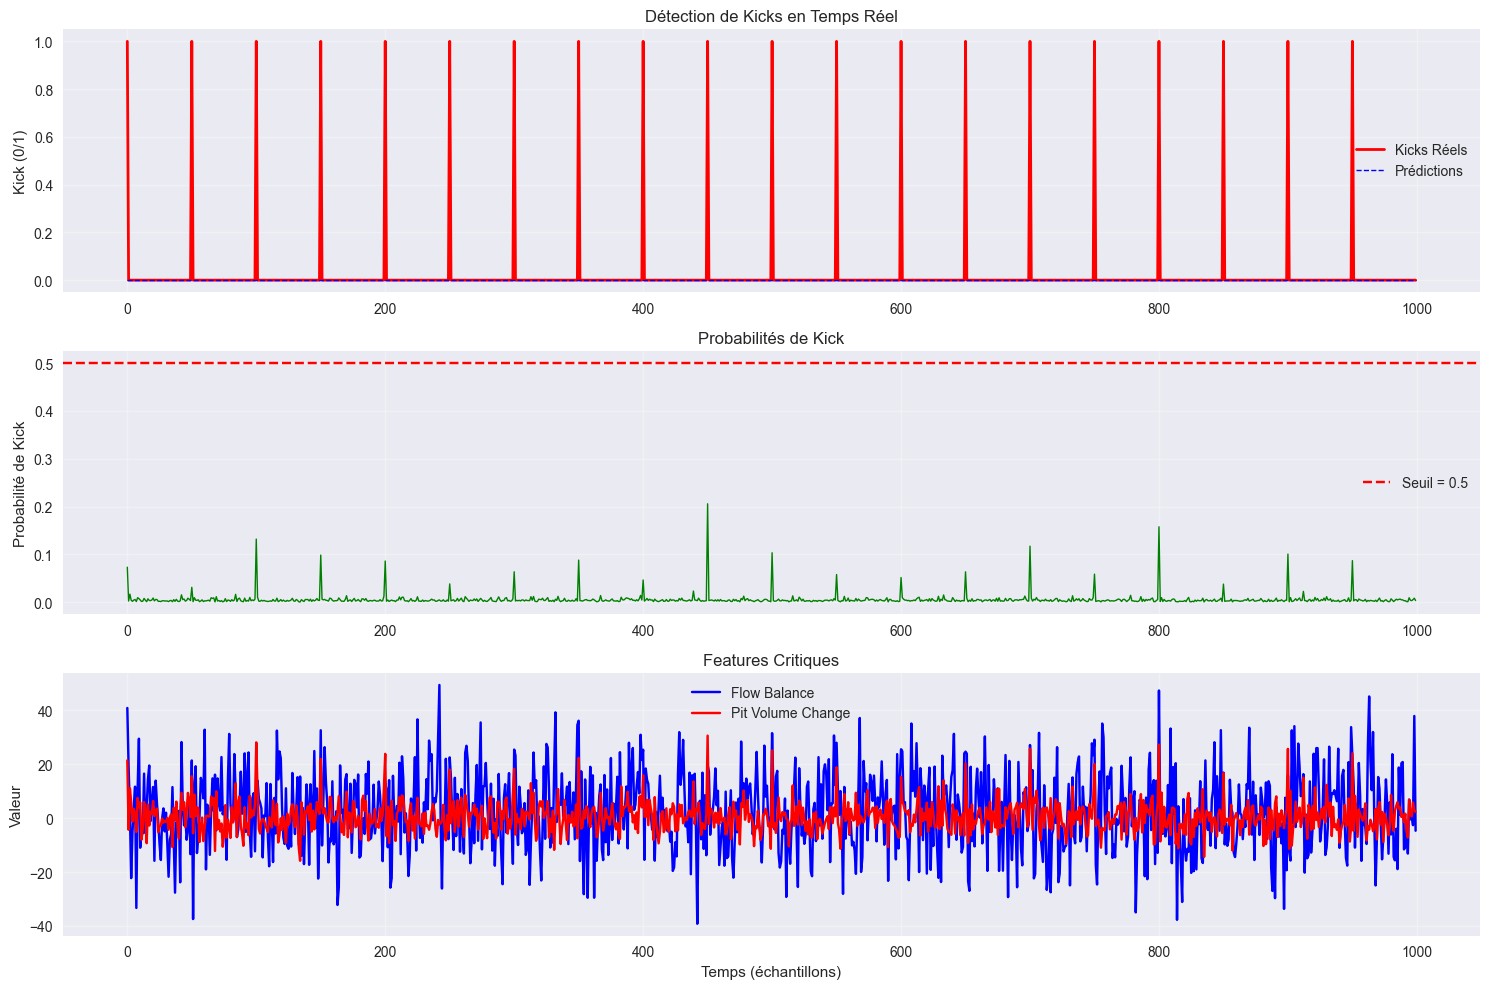


ÉVALUATION COMPLÈTE TERMINÉE


In [34]:
print("\n" + "="*60)
print("SIMULATION DE PERFORMANCE TEMPS RÉEL")
print("="*60)

def simulate_real_time_performance():
    """Simule la performance en temps réel"""
    
    # Simulation de données en streaming
    np.random.seed(123)
    streaming_samples = 1000
    
    # Générer des données de streaming
    streaming_data = []
    for i in range(streaming_samples):
        # Simuler des conditions normales vs anormales
        if i % 50 == 0:  # Kick simulation every 50 samples
            # Conditions de kick
            sample = {
                'FIn': np.random.normal(300, 10),
                'FOut': np.random.normal(320, 10),  # Augmentation du flow out
                'ActiveGL': np.random.normal(120, 5),  # Augmentation pit volume
                'StandPipePress': np.random.normal(2200, 50),  # Augmentation pression
                'CasingPress': np.random.normal(500, 50),
                'MRFlow': np.random.normal(295, 10),
                'HookLoad': np.random.normal(150, 15),
                'IsKick': 1
            }
        else:
            # Conditions normales
            sample = {
                'FIn': np.random.normal(300, 10),
                'FOut': np.random.normal(302, 10),
                'ActiveGL': np.random.normal(100, 5),
                'StandPipePress': np.random.normal(2000, 50),
                'CasingPress': np.random.normal(500, 50),
                'MRFlow': np.random.normal(295, 10),
                'HookLoad': np.random.normal(150, 15),
                'IsKick': 0
            }
        
        # Ajouter features engineered
        sample['FlowBalance'] = sample['FOut'] - sample['FIn']
        sample['FlowRatio'] = sample['FOut'] / sample['FIn']
        sample['FlowImbalance'] = abs(sample['FlowBalance'])
        sample['PressureDiff'] = sample['StandPipePress'] - sample['CasingPress']
        
        streaming_data.append(sample)
    
    streaming_df = pd.DataFrame(streaming_data)
    
    # Test du meilleur modèle de kick detection
    best_kick_model_name = classification_df.loc[classification_df['Test_Recall'].idxmax(), 'Model']
    best_kick_model = evaluator.kick_models[best_kick_model_name]
    
    # Préparation des données
    X_streaming = streaming_df.drop(['IsKick'], axis=1)
    y_streaming = streaming_df['IsKick']
    
    # Standardisation
    X_streaming_scaled = scaler_kick.transform(X_streaming)
    
    # Prédictions
    if best_kick_model_name in ['Logistic Regression', 'Support Vector']:
        predictions = best_kick_model.predict(X_streaming_scaled)
        probabilities = best_kick_model.predict_proba(X_streaming_scaled)[:, 1]
    else:
        predictions = best_kick_model.predict(X_streaming)
        probabilities = best_kick_model.predict_proba(X_streaming)[:, 1]
    
    # Métriques en temps réel
    accuracy = accuracy_score(y_streaming, predictions)
    precision = precision_score_safe(y_streaming, predictions)
    recall = recall_score_safe(y_streaming, predictions)
    f1 = f1_score(y_streaming, predictions, zero_division=0)
    
    print(f"Performance Temps Réel - {best_kick_model_name}:")
    print(f"• Échantillons traités: {len(streaming_data)}")
    print(f"• Kicks réels: {y_streaming.sum()}")
    print(f"• Accuracy: {accuracy:.4f}")
    print(f"• Precision: {precision:.4f}")
    print(f"• Recall: {recall:.4f}")
    print(f"• F1 Score: {f1:.4f}")
    
    # Visualisation des prédictions en temps réel
    plt.figure(figsize=(15, 10))
    
    # Timeline des prédictions
    plt.subplot(3, 1, 1)
    time_axis = range(len(y_streaming))
    plt.plot(time_axis, y_streaming, 'r-', label='Kicks Réels', linewidth=2)
    plt.plot(time_axis, predictions, 'b--', label='Prédictions', linewidth=1)
    plt.ylabel('Kick (0/1)')
    plt.legend()
    plt.title('Détection de Kicks en Temps Réel')
    plt.grid(True, alpha=0.3)
    
    # Probabilités de kick
    plt.subplot(3, 1, 2)
    plt.plot(time_axis, probabilities, 'g-', linewidth=1)
    plt.axhline(y=0.5, color='r', linestyle='--', label='Seuil = 0.5')
    plt.ylabel('Probabilité de Kick')
    plt.legend()
    plt.title('Probabilités de Kick')
    plt.grid(True, alpha=0.3)
    
    # Features importantes en temps réel
    plt.subplot(3, 1, 3)
    plt.plot(time_axis, streaming_df['FlowBalance'], 'b-', label='Flow Balance')
    plt.plot(time_axis, streaming_df['ActiveGL'] - 100, 'r-', label='Pit Volume Change')
    plt.ylabel('Valeur')
    plt.xlabel('Temps (échantillons)')
    plt.legend()
    plt.title('Features Critiques')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'samples_processed': len(streaming_data)
    }

# Simulation temps réel
rt_performance = simulate_real_time_performance()

print(f"\n{'='*80}")
print("ÉVALUATION COMPLÈTE TERMINÉE")
print(f"{'='*80}")